In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel(r"C:\Repos\events_analyzer\data\Показатели Экономика данных.xlsx")

In [6]:
main_df = df.copy()
main_df.head()
main_df.shape

(15672, 17)

In [7]:
main_df = main_df.iloc[:, 1]
main_df

0        Обеспечено развитие и/или сопровождение функци...
1        Обеспечено развитие и/или сопровождение функци...
2        Обеспечено развитие и/или сопровождение функци...
3        Обеспечено развитие и/или сопровождение функци...
4        Обеспечено развитие и/или сопровождение функци...
                               ...                        
15667    Реализованы проекты малых предприятий, в том ч...
15668    Реализованы проекты малых предприятий, в том ч...
15669    Реализованы проекты малых предприятий, в том ч...
15670    Реализованы проекты малых предприятий, в том ч...
15671    Реализованы проекты малых предприятий, в том ч...
Name: Наименование результата, Length: 15672, dtype: object

In [18]:
OUTPUT_EMB = "C:\Repos\events_analyzer\data\data_col0.csv"
OUTPUT_NPY = "C:\Repos\events_analyzer\data\data_bytes.npy"

<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:2: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:2: SyntaxWarning: invalid escape sequence '\R'
C:\Users\Alex\AppData\Local\Temp\ipykernel_26168\980920703.py:1: SyntaxWarning: invalid escape sequence '\R'
  OUTPUT_EMB = "C:\Repos\events_analyzer\data\data_col0.csv"
C:\Users\Alex\AppData\Local\Temp\ipykernel_26168\980920703.py:2: SyntaxWarning: invalid escape sequence '\R'
  OUTPUT_NPY = "C:\Repos\events_analyzer\data\data_bytes.npy"


In [23]:
TEXT_COLUMN = 0
MODEL_NAME  = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

def text_to_embeddings(df) -> str:
    texts = df.iloc[:, TEXT_COLUMN].astype(str).fillna("").tolist()
    model = SentenceTransformer(MODEL_NAME)
    embeddings = model.encode(
        texts,
        batch_size=32,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True
    )
    np.save(OUTPUT_NPY, embeddings) 
    df_out = pd.DataFrame({
        "event_id": range(len(texts)),
        "title": texts
    })
    df_out.to_csv(OUTPUT_EMB, index=False, encoding="utf-8")

    return "Ready"

In [ ]:
text_to_embeddings(main_df)

Batches: 100%|██████████| 40/40 [00:03<00:00, 10.63it/s]


'Ready'

In [29]:
embeddings = np.load(r"C:\Repos\events_analyzer\data\data_bytes.npy")
embeddings.shape

(1257, 384)

Найдено кластеров: 317 (шумовых точек: 940)


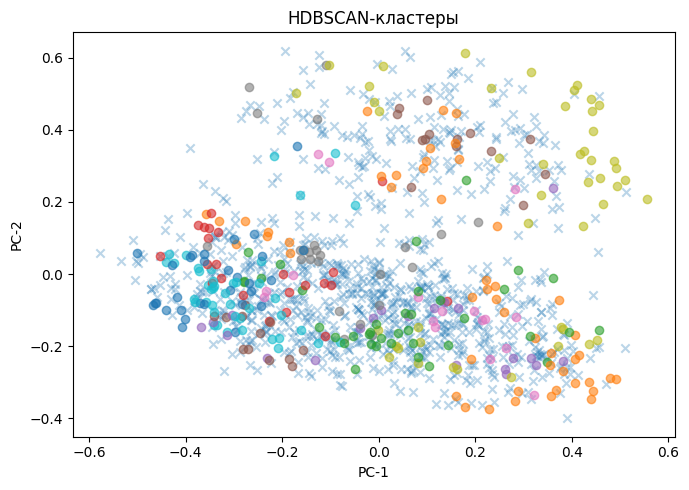

In [52]:
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA 

clustering = HDBSCAN(min_samples=5,
                    metric="cosine",
                    min_cluster_size=5,
                    cluster_selection_method="leaf",
                    ).fit(embeddings)

labels = clustering.labels_
print(f"Найдено кластеров: {(labels >= 0).sum()} (шумовых точек: {(labels==-1).sum()})")

pca = PCA(n_components=2, random_state=42)   
coords = pca.fit_transform(embeddings) 

plt.figure(figsize=(7, 5))
for lab in np.unique(labels):
    mask = labels == lab
    # Lab == -1 → «шум»; рисуем крестиками
    plt.scatter(
        coords[mask, 0],
        coords[mask, 1],
        alpha=0.6 if lab != -1 else 0.3,
        marker='x' if lab == -1 else 'o',
        label='noise' if lab == -1 else f'cluster {lab}'
    )

plt.title("HDBSCAN-кластеры")
plt.xlabel("PC-1")
plt.ylabel("PC-2")
plt.tight_layout()

In [14]:
import pandas as pd
import argparse
import sys



def merge_unique_pairs(input_files, output_file):
    """
    Объединяет несколько CSV-файлов и сохраняет все столбцы, удаляя дубликаты по парам a_id, b_id.

    Параметры:
        input_files (list of str): пути к входным CSV-файлам.
        output_file (str): путь к выходному CSV-файлу.

    Возвращает:
        pandas.DataFrame: датафрейм с уникальными строками по a_id и b_id.
    """
    dfs = []
    for filepath in input_files:
        df = pd.read_csv(filepath)
        if not {'A_id', 'B_id'}.issubset(df.columns):
            raise ValueError(f"В файле {filepath} отсутствуют столбцы 'a_id' или 'b_id'.")
        dfs.append(df)

    # Объединяем все строки из файлов
    combined = pd.concat(dfs, ignore_index=True)
    # Удаляем дубликаты по ключам a_id, b_id, сохраняя первую встреченную строку целиком
    unique_rows = combined.drop_duplicates(subset=['A_id', 'B_id'], keep='first')

    # Сохраняем результат со всеми столбцами
    unique_rows.to_csv(output_file, index=False)
    return unique_rows


def build_risk_matrix(df, index_col='A_id', columns_col='B_id', value_col='risk', output_file=None):
    """
    Формирует матрицу рисков из DataFrame с колонками a_id, b_id и risk.

    Параметры:
        df (pandas.DataFrame): входной датафрейм с уникальными парами и значениями риска.
        index_col (str): имя колонки для индексов (строки).
        columns_col (str): имя колонки для колонок матрицы.
        value_col (str): имя колонки со значениями риска.
        output_file (str, optional): путь для сохранения матрицы в CSV. Если None — не сохраняет.

    Возвращает:
        pandas.DataFrame: pivot-матрицу с индексами a_id, столбцами b_id и значениями risk.
    """
    if not {index_col, columns_col, value_col}.issubset(df.columns):
        missing = {index_col, columns_col, value_col} - set(df.columns)
        raise ValueError(f"Отсутствуют колонки: {', '.join(missing)}")

    matrix = df.pivot(index=index_col, columns=columns_col, values=value_col)
    if output_file:
        matrix.to_csv(output_file)
    return matrix


In [16]:
input_files = ["/home/rashid/repos/временно/merged_unique_pairs.csv","/home/rashid/repos/временно/risk_matrix.csv"]
output_file = "/home/rashid/repos/временно/merged_unique_pairs.csv"
merged_df = merge_unique_pairs(input_files, output_file)
print(f"Уникальные пары сохранены в {output_file}")

Уникальные пары сохранены в /home/rashid/repos/временно/merged_unique_pairs.csv


In [15]:
matrix_output = 'risk_matrix_pivot.csv'
risk_matrix = build_risk_matrix(merged_df, 'A_id', 'B_id', 'risk', matrix_output)
print(f"Матрица рисков сохранена в '{matrix_output}'")

Матрица рисков сохранена в 'risk_matrix_pivot.csv'
